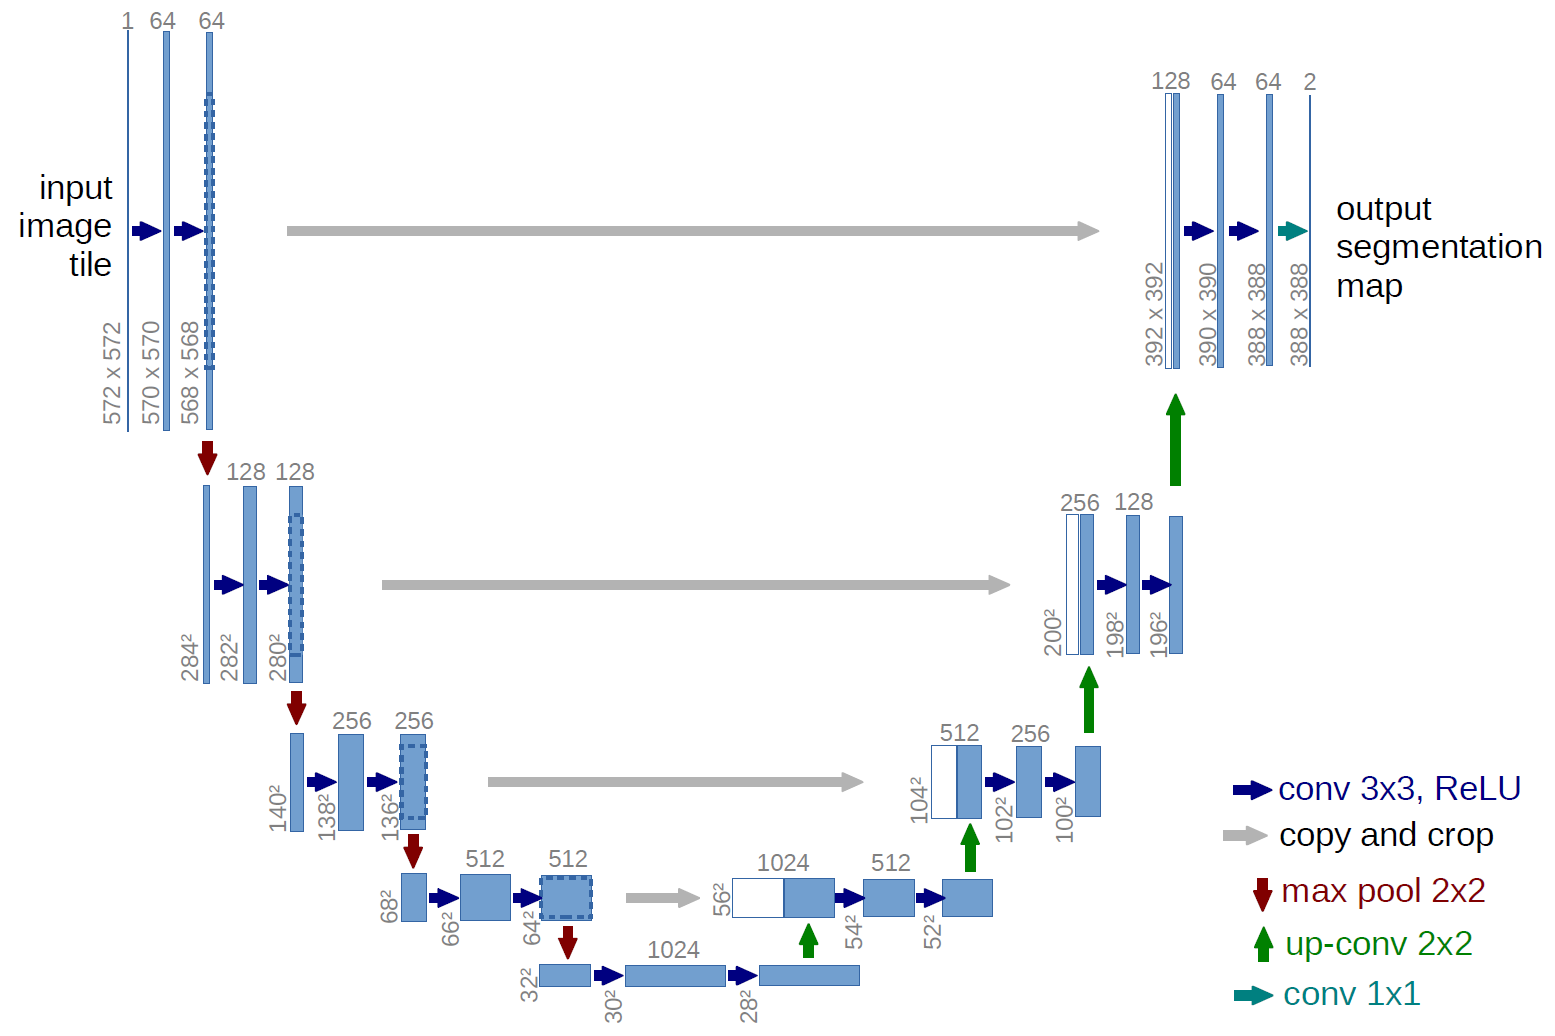

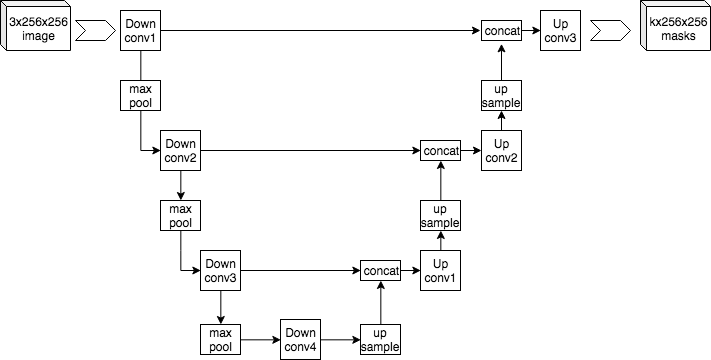

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class ConvBlock(keras.Model):
  def __init__(self,in_channels):
    super(ConvBlock,self).__init__()
    self.in_channels = in_channels
    self.conv = keras.Sequential([layers.ZeroPadding2D(padding=(1,1)), 
                                  layers.Conv2D(filters=self.in_channels,kernel_size=(3,3),strides=(1,1),use_bias=False),
                                  layers.BatchNormalization(),
                                  layers.ReLU(),
                                  
                                  layers.ZeroPadding2D(padding=(1,1)), 
                                  layers.Conv2D(filters=self.in_channels,kernel_size=(3,3),strides=(1,1),use_bias=False),
                                  layers.BatchNormalization(),
                                  layers.ReLU(),
                                  ])

  def call(self,input_tensor):
    return self.conv(input_tensor)

In [3]:
#unit test
#model = ConvBlock(64)
#y = tf.random.uniform((2,32,32,3))
#print(model(y).shape)

In [4]:
class Unet(keras.Model):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(Unet, self).__init__()
        self.ups = []
        self.downs = []
        self.pool = layers.MaxPool2D(pool_size=2, strides=2)
        self.in_channels= in_channels
        self.features=features

        # Downsampling 
        for feature in features:
            self.downs.append(ConvBlock(in_channels))
            in_channels = feature

        # Upsampling
        for feature in reversed(features):
  
            self.ups.append(layers.Conv2DTranspose(feature*2, kernel_size=(2,2), strides=2,))
            self.ups.append(ConvBlock(feature*2))

        self.bottleneck = keras.Sequential([layers.ZeroPadding2D(padding=(1,1)), 
                                            layers.Conv2D(filters=self.features[-1],kernel_size=(3,3),strides=(1,1)),
                                            layers.BatchNormalization(),
                                            layers.ReLU(),
                                            layers.ZeroPadding2D(padding=(1,1)), 
                                            layers.Conv2D(filters=self.features[-1]*2,kernel_size=(3,3),strides=(1,1)),
                                            layers.BatchNormalization(),
                                            layers.ReLU()])
        self.final_conv = layers.Conv2D(features[0], kernel_size=1)

    def call(self, x):
      skip_connections = []
      for down in self.downs:
        x = down(x)
#       print("x shape:    ",x.shape)
        skip_connections.append(x)
#       print("x shape:    ",x.shape)

        x = self.pool(x)
#       print("x shape:    ",x.shape)

      x = self.bottleneck(x)
        # the first is the one with the highest resolution and the last is the one with the lowest resolution
      skip_connections = skip_connections[::-1]

      for i in range(0, len(self.ups), 2):
        x = self.ups[i](x)
#        print("x shape:    ",x.shape)
        skip_connection = skip_connections[i//2]
#        print("skip_connection shape:    ",skip_connection.shape)
#        print("x shape:    ",x.shape)
        concat_skip = layers.concatenate([skip_connection,x], axis=3)
        x = self.ups[i+1](concat_skip)
#        print(x.shape)
      x = self.final_conv(x)
      return layers.Conv2D(filters=3, kernel_size=1)(x)


In [5]:
x = tf.random.uniform((1,160, 160,3))
model = Unet(in_channels=1,features=[64, 128, 256, 512])
preds = model(x)
assert preds.shape == x.shape
print(preds.shape)


(1, 160, 160, 3)
